# Deconvolution algorithm controlled by the accumulator 

In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import system_of_units as units
import tables
import mplFunctions as mpl
import wfmFunctions as wfm

In [3]:
import FEE as FE

In [4]:
import time

In [5]:
import pandas as pd

In [111]:
from coreFunctions import wait

In [134]:
from Database import loadDB

## Revised on:

In [6]:
print(time.strftime("%d/%m/%Y"))

11/11/2016


In [7]:
print(time.strftime("%H:%M:%S"))

14:49:10


###  Code exercized

In [8]:
!pep8 ../../Sierpe/FEE.py

/bin/sh: pep8: command not found


In [8]:
!pyflakes ../../Sierpe/FEE.py

### Monte Carlo data

1. Running on electrons of fixed energy (40, 1250, 2500 keV)  in the center of chamber.
2. Nominal yield factor in current NEW conditions (7 bar, 7 kV in gate) is 574 photons/e
3. Monte Carlo yield factor 690 photons/e
4. Running of Kripton, Na, Tl, with yield factor 574 photons/e

In [11]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


#### List the files

In [12]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Na_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Tl_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5
electrons.1250.0keV.z250mm.next_10.root.h5
electrons.1250.0keV.z250mm.next_100.root.h5
electrons.1250.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10.root.h5
electrons.2500.0keV.z250mm.next_100.root.h5
electrons.2500.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10000.root.h5
electrons.40.0keV.z250mm.next_10.root.h5
electrons.40.0keV.z250mm.next_100.root.h5
electrons.40.0keV.z250mm.next_1000.root.h5
electrons.40.0keV.z250mm.next_10000.root.h5
run_2609_kr.root.h5
run_2644.gdc1next.000.next1el_2644.root.h5
run_2644.gdc1next.001.next1el_2644.root.h5
run_2644.gdc1next.003.next1el_2644.roo

### Files

#### Kripton Na-22 and Th at 7bar 

In [18]:
kr7bar = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5','r+')

In [19]:
na7bar = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5','r+')

In [20]:
Tl7bar = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_HEAD_Tl_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5','r+')

#### Electrons of fixed energy

In [21]:
e2500 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.2500.0keV.z250mm.next_1000.root.h5','r+')

In [22]:
e1250 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.1250.0keV.z250mm.next_1000.root.h5','r+')

In [23]:
e40 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_1000.root.h5','r+')

## SIMULATING THE EFFECT OF ELECTRONICS OVER MC DATA

### PROCEDURE

1. Read MCRD (bins of 1 ns).
2. Convolute with SPE response to form a signal_i (units of A)
3. Decimate the signal.
4. Simulate the effect of the filter.

In [26]:
def fee_response(pmtrd, event=0):
    """
    input: pmtrd vector
    returns: a data frame with the PMT waveforms
    """
    spe = FE.SPE()
    fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
    NPMT = pmtrd.shape[1]
    
    RWF = []
    BLRX = []
    for pmt in range(NPMT):
        signal_i = FE.spe_pulse_from_vector(spe, pmtrd[event,pmt])  # in current units  
        signal_d = FE.daq_decimator(FE.f_mc, FE.f_sample, signal_i)
        signal_fee = FE.signal_v_fee(fee, signal_d)*FE.v_to_adc()  #in adc counts
        signal_daq = FE.noise_adc(fee, signal_fee)
        signal_blr = signal_d*FE.i_to_adc()
        
        RWF.append(FE.OFFSET - signal_daq)
        #RWF.append(signal_daq)
        BLRX.append(signal_blr)
    
    return np.array(RWF), np.array(BLRX)

#### Electrons of 40 keV

In [27]:
RWF, BLRX = fee_response(e40.root.pmtrd, event=0) 

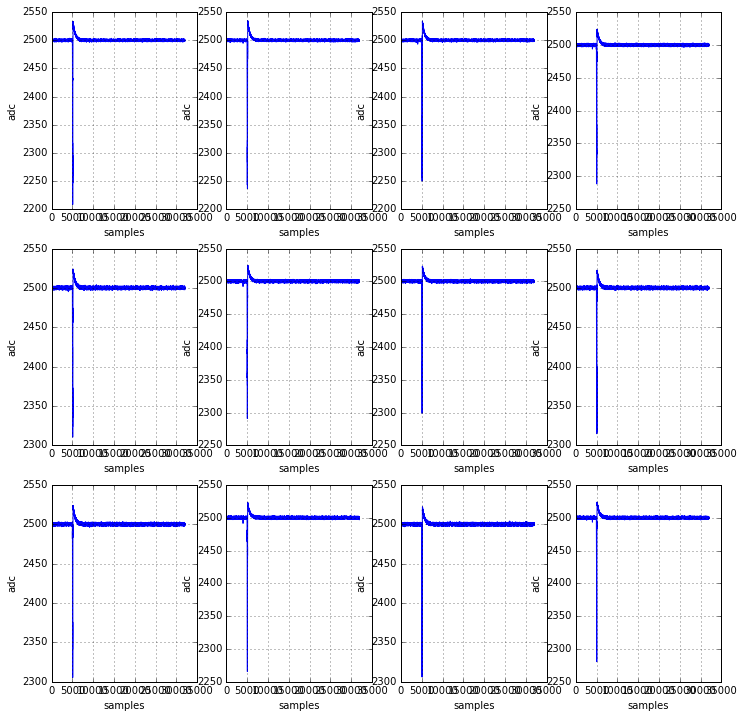

In [28]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=False, window_size=800)

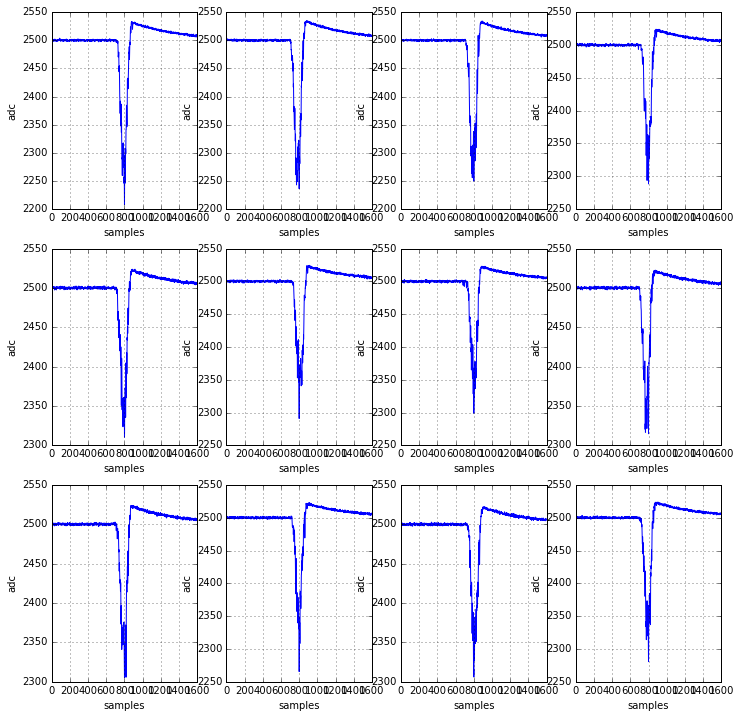

In [29]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=800)

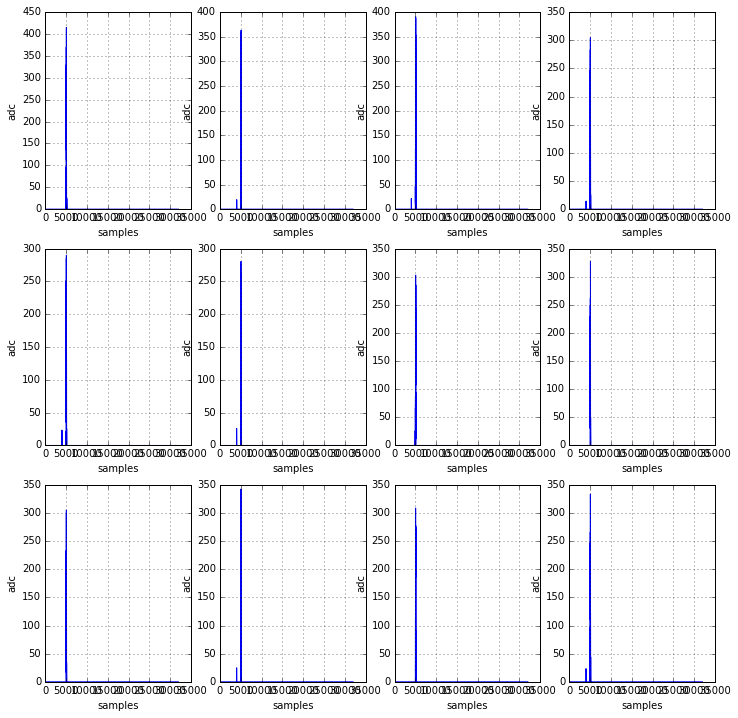

In [30]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=False, window_size=800)

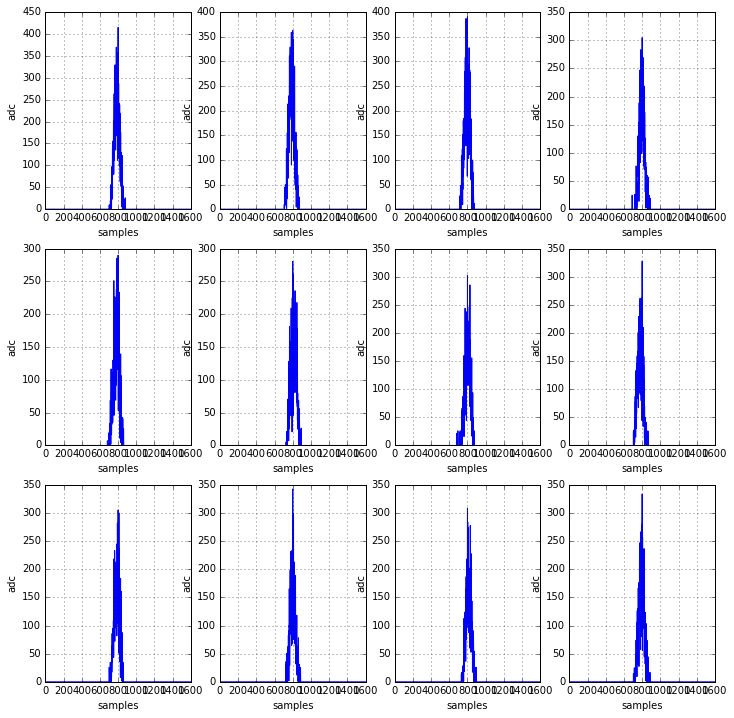

In [31]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=True, window_size=800)

#### True energy in pes (electrons of 40 keV nominal gain ¡)

In [36]:
e40DF = wfm.get_energy(e40.root.pmtrd, event_list=[0])

In [37]:
e40DF

,0,1,2,3,4,5,6,7,8,9,10,11
0,1210.0,1263.0,1195.0,881.0,857.0,861.0,824.0,820.0,864.0,831.0,814.0,843.0


#### True energy in pes (Kripton 7 kV t bar)

In [38]:
eKr7barDF = wfm.get_energy(kr7bar.root.pmtrd, event_list=[0]) 

In [39]:
eKr7barDF

,0,1,2,3,4,5,6,7,8,9,10,11
0,854.0,914.0,987.0,692.0,692.0,717.0,706.0,675.0,666.0,652.0,683.0,672.0


In [40]:
eKr7barDF/e40DF

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.705785,0.723674,0.825941,0.785471,0.807468,0.832753,0.856796,0.823171,0.770833,0.784597,0.839066,0.797153


## Deconvolution

### Discharge function

In [41]:
def discharge_acum(length_d=5000, tau=2500, compress=0.005):
    t_discharge = np.arange(0,length_d,1,dtype=np.double)
    discharge_curve = compress*(1-1/(1+np.exp(-(t_discharge-length_d/2)/tau)))+(1-compress)
    return discharge_curve


In [ ]:
def deplete_acum(t, tau=2500, compress=0.005):
    t_discharge = np.arange(0,length_d,1,dtype=np.double)
    f = 1. + np.exp(-(t_discharge-length_d/2)/tau))
    discharge_curve = compress*(1-1/(1+np.exp(-(t_discharge-length_d/2)/tau)))+(1-compress)
    return discharge_curve

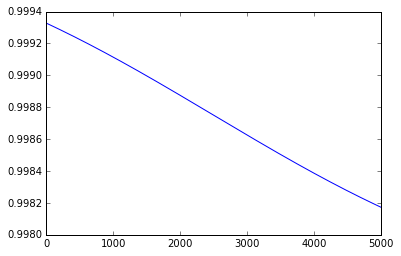

In [42]:
plt.plot(discharge_acum(length_d=5000, tau=2500, compress=0.0025))

### Accumulator controlled BLR

In [181]:
def deconvolve_signal_acum(signal_i, n_baseline=500, noise_rms= 0.8,
                      coef_clean=2.905447E-06, coef_blr=1.632411E-03, 
                      thr_trigger=5, thr_acum=1000, coeff_acum = 0.9995,
                      acum_discharge_length = 5000, acum_tau=2500, acum_compress=0.0025,
                      filter_c=True):

    """
    The accumulator approach by Master VHB

    """
    
    coef = coef_blr
    nm = n_baseline
    
    len_signal_daq = len(signal_i)
    
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    pulse_on = np.zeros(len_signal_daq, dtype=np.int8)
    j_reg = np.zeros(len_signal_daq, dtype=np.double)
    trigger = np.zeros(len_signal_daq, dtype=np.double)
    MAU = np.zeros(len_signal_daq, dtype=np.double)
    
    # signal_daq in floats
    signal_daq = signal_i.astype(float)
    # baseline and noise. Start the MAU with the value of the baseline
    baseline = np.mean(signal_daq[0:nm])
    noise_rms = np.std(signal_daq[0:nm],ddof=1)
    
    
    
    # change sign and subtract baseline
    signal_daq =  baseline - signal_daq
    
    # clean the signal_daq
    if filter_c==True:
        b_cf, a_cf = signal.butter(1, coef_clean, 'high', analog=False);
        signal_daq = signal.lfilter(b_cf,a_cf,signal_daq)
        

    discharge_curve = discharge_acum(length_d=acum_discharge_length, tau=acum_tau, 
                                compress=acum_compress)
    j=0
 
    # BLR
    signal_r[0:nm] = signal_daq[0:nm] 
    p_on = 0
    
    MAU[0:nm] = np.mean(signal_daq[0:nm])
    
    print ("baseline = {}, noise (LSB_rms) = {} MAU[nm] ={} ".format(
            baseline, noise_rms, MAU[nm]))
    
    trigger_line = thr_trigger*noise_rms
    for k in range(nm,len_signal_daq): 
        
        
        pulse_on[k] = p_on
        trigger[k] = trigger_line
        
        # update recovered signal
        signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
        
        # condition: raw signal raises above trigger line 
        if (signal_daq[k] > trigger_line) or (acum[k-1] > thr_acum):
            
            if p_on == 0:
                p_on = 1
                 # take the value of the offset as the baseline average in k-1
                offset = MAU[k-1] 
                #print ("k = {} offset = {}, trigger line = {}, signal_daq[k] ={} acum[k-1] = {}".\
                #       format(k, offset, trigger_line,signal_daq[k],acum[k-1] ))
            
            MAU[k] = MAU[k-1]  # slide the MAU
            
            #signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            # update de accumulator until it drops below thr_acum
            #acum[k] = acum[k-1] + signal_daq[k] - MAU[k]
            acum[k] = acum[k-1] + signal_daq[k] 
           
                   
        else:
            if p_on == 1:
                p_on = 0
                j = 0
            
            MAU[k] = np.mean(signal_daq[k-nm:k])  # update the baseline
                
            #signal_r[k] = signal_daq[k]
            # deplete the accumulator before or after the signal to avoid runoffs
            #if acum[k-1]>0:
            #    acum[k]=acum[k-1]*coeff_acum
            
            # discharge acumulator
            
            if acum[k-1]>1:
                acum[k] = acum[k-1]*discharge_curve[j]
                if j<acum_discharge_length-1:
                    j=j+1
                else:
                    j=acum_discharge_length-1
            else:
                acum[k]=0
                j=0
            
#             if k > 4977 and k < 4982:
#                 print ("k = {}, signal_daq[k] ={} MAU[k] ={}".\
#                        format(k, signal_daq[k],MAU[k],  ))
                
#                 print ("j = {} discharge_curve[j] = {}, acum[k-1] = {} acum[k] = {} ".\
#                        format(j, discharge_curve[j],acum[k-1],acum[k]))
            
#             if k > 6600 and k < 6610:
#                 print ("k = {}, signal_daq[k] ={} MAU[k] ={}".\
#                        format(k, signal_daq[k],MAU[k],  ))
                
#                 print ("j = {} discharge_curve[j] = {}, acum[k-1] = {} acum[k] = {} ".\
#                        format(j, discharge_curve[j],acum[k-1],acum[k]))
            
                
        j_reg[k]=j 
    
    BLR={}
    BLR['acum'] = acum
    BLR['pulse_on'] = pulse_on
    BLR['signal_daq'] = signal_daq
    BLR['signal_r'] = signal_r
    BLR['MAU'] = MAU
    BLR['j_reg'] = j_reg
    BLR['trigger'] = trigger
    
    return pd.DataFrame(BLR)

In [44]:
signal_daq = RWF[0]

In [45]:
fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
freq_zero = 1./(fee.R1*fee.C1)
freq_zerod = freq_zero/(fee.f_sample*np.pi)
coef_c = freq_zerod
coef_blr = fee.freq_LHPFd*np.pi
print('coef_c = {}'.format(coef_c))
print('coef_blr = {}'.format(coef_blr)) 

coef_c = 1.87116159952e-06
coef_blr = 0.00192400951255


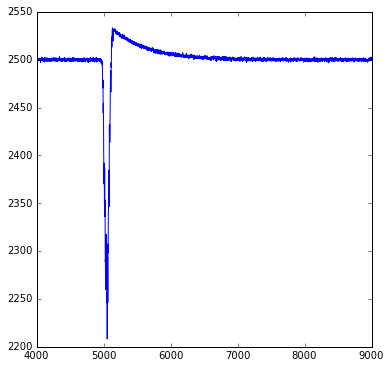

In [47]:
plt.figure(figsize=(6, 6))
xmin=4000
xmax=9000
plt.plot(range(xmin,xmax),signal_daq[xmin:xmax])

In [105]:
BLR = deconvolve_signal_acum(signal_daq, n_baseline=500, noise_rms= 0.8,
                      coef_clean=coef_c, coef_blr=coef_blr, 
                      thr_trigger=5, thr_acum=1000, coeff_acum = 0.9995,
                      acum_discharge_length = 5000, acum_tau=2500, acum_compress=0.0025,
                      filter_c=True)


baseline = 2499.96613401, noise (LSB_rms) = 0.825157307482 MAU[nm] =0.0 


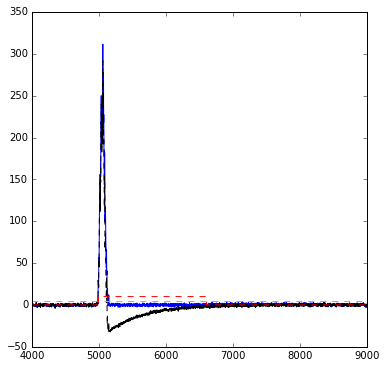

In [84]:
plt.figure(figsize=(6, 6))
xmin=4000
xmax=9000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

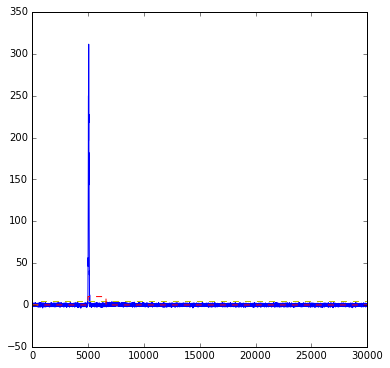

In [87]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=30000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

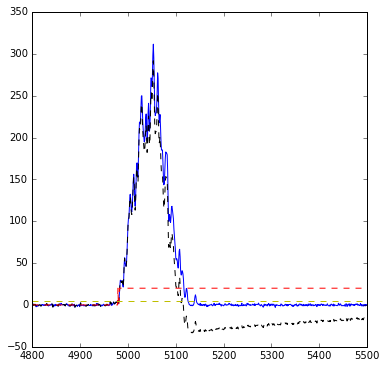

In [88]:
plt.figure(figsize=(6, 6))
xmin=4800
xmax=5500
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR.signal_daq[xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*20,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)

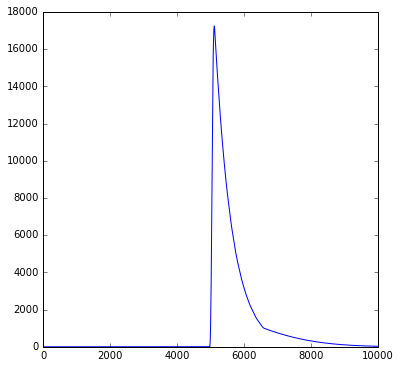

In [89]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=10000
plt.plot(range(xmin,xmax),BLR.acum[xmin:xmax])

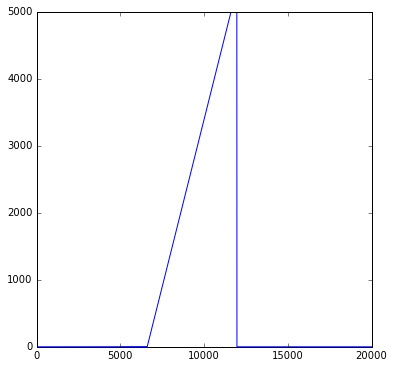

In [91]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=20000
plt.plot(range(xmin,xmax),BLR.j_reg[xmin:xmax])

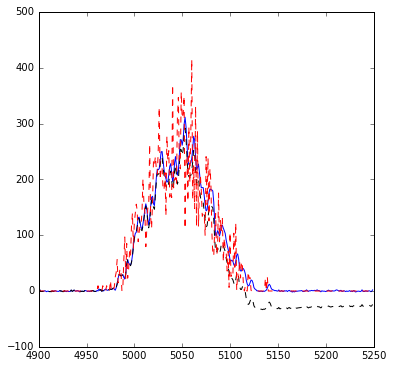

In [96]:
plt.figure(figsize=(6, 6))
xmin=4900
xmax=5250
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax),BLRX[0][xmin:xmax],'r--')

In [101]:
xmin=4900
xmax=5250
print('True energy in adc counts (BLRX[xmin:xmax] = {}, BLR[:] = {} rec energy = {})'.format(
    np.sum(BLRX[0][xmin:xmax]), np.sum(BLRX[0]), np.sum(BLR.signal_r[xmin:xmax]) ))
print('True energy in pes = {}, ratio (adc_to_pes) = {})'.format(e40DF[0][0],
                                                                 np.sum(BLRX[0])/e40DF[0][0] ))

True energy in adc counts (BLRX[xmin:xmax] = 19874.1902873, BLR[:] = 19874.1902873 rec energy = 19814.8071235)
True energy in pes = 1210.0, ratio (adc_to_pes) = 16.4249506507)


In [95]:
xmin=4950
xmax=5150
np.sum(BLR.signal_r[xmin:xmax])

19823.530973171022

In [115]:
def blr_stats(pmtrd, event_list=[0], xmin=4900, xmax=5150, pmtid=0, plot=False):
    ER = np.zeros(len(event_list), dtype=np.double)
    
    for i, event in enumerate(event_list):
        print('event = {}'.format(event))
        RWF, BLRX = fee_response(pmtrd, event=event)
        BLR = deconvolve_signal_acum(RWF[pmtid], n_baseline=500, noise_rms= 0.8,
                      coef_clean=coef_c, coef_blr=coef_blr, 
                      thr_trigger=5, thr_acum=1000, coeff_acum = 0.9995,
                      acum_discharge_length = 5000, acum_tau=2500, acum_compress=0.0025,
                      filter_c=True)

        
        energy_mea=np.sum(BLR.signal_r[xmin:xmax])
        energy_in=np.sum(BLRX[pmtid][xmin:xmax])
        ER[i] = 100*abs(energy_mea - energy_in)/energy_in
        
        if plot == True:
            plt.figure(figsize=(6, 6))
            plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
            plt.plot(range(xmin,xmax),BLRX[pmtid][xmin:xmax],'r--', linewidth=1)
            print('Input Energy = {}'.format(energy_in))
            plt.show()
            print('Reconstructed Energy = {}'.format(energy_mea))
            print('Error in Energy Computation (%) = {}'.format(ER[i]))
            wait()
    return ER
  

event = 0
baseline = 2499.85071733, noise (LSB_rms) = 0.948585359349 MAU[nm] =0.0 
Input Energy = 19874.1902873


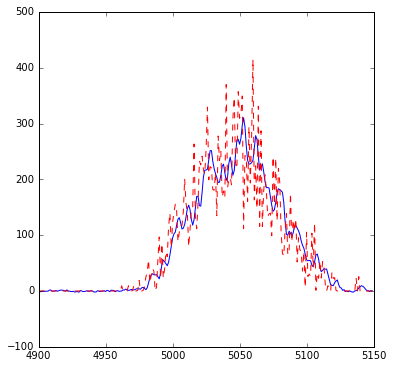

Reconstructed Energy = 19803.1808684
Error in Energy Computation (%) = 0.357294651617
Press a key...
event = 1
baseline = 2499.99871799, noise (LSB_rms) = 0.856463621349 MAU[nm] =0.0 
Input Energy = 20863.2099178


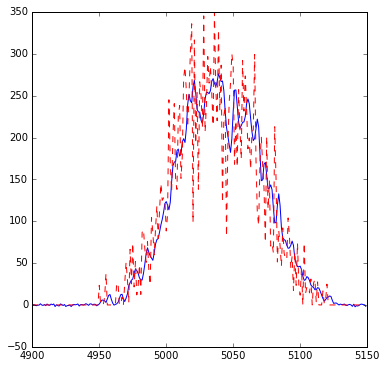

Reconstructed Energy = 20853.8484805
Error in Energy Computation (%) = 0.0448705514217
Press a key...
event = 2
baseline = 2499.98050247, noise (LSB_rms) = 0.884112186004 MAU[nm] =0.0 
Input Energy = 21082.5573131


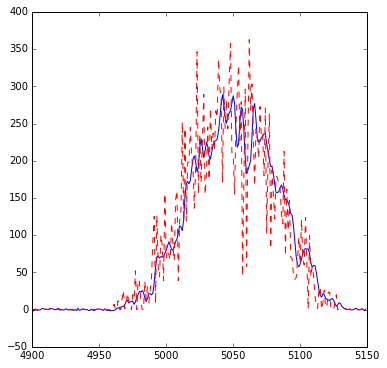

Reconstructed Energy = 21059.0426918
Error in Energy Computation (%) = 0.111535906243
Press a key...
event = 3
baseline = 2499.98899901, noise (LSB_rms) = 0.802202020211 MAU[nm] =0.0 
Input Energy = 20413.0076922


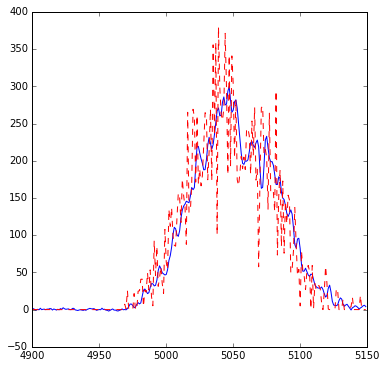

Reconstructed Energy = 20427.1444498
Error in Energy Computation (%) = 0.0692536728099
Press a key...
event = 4
baseline = 2499.91025069, noise (LSB_rms) = 0.829288387724 MAU[nm] =0.0 
Input Energy = 20718.940516


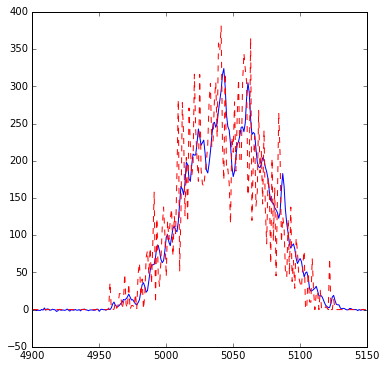

Reconstructed Energy = 20667.1467922
Error in Energy Computation (%) = 0.249982491936
Press a key...
event = 5
baseline = 2499.99480276, noise (LSB_rms) = 0.85778441658 MAU[nm] =0.0 
Input Energy = 20302.0645215


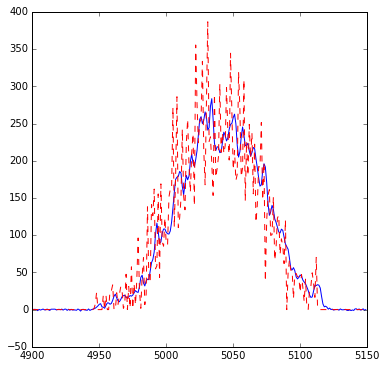

Reconstructed Energy = 20299.000882
Error in Energy Computation (%) = 0.0150902854914
Press a key...
event = 6
baseline = 2499.96972459, noise (LSB_rms) = 0.834637693425 MAU[nm] =0.0 
Input Energy = 20300.8672965


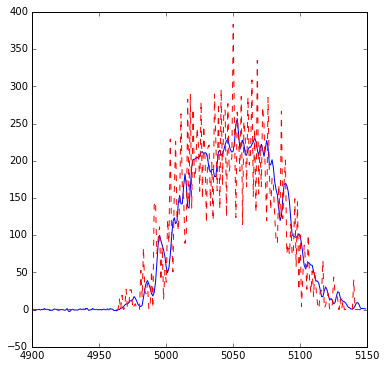

Reconstructed Energy = 20290.4046608
Error in Energy Computation (%) = 0.0515378758293
Press a key...
event = 7
baseline = 2499.96927886, noise (LSB_rms) = 0.904457993744 MAU[nm] =0.0 
Input Energy = 19723.0596734


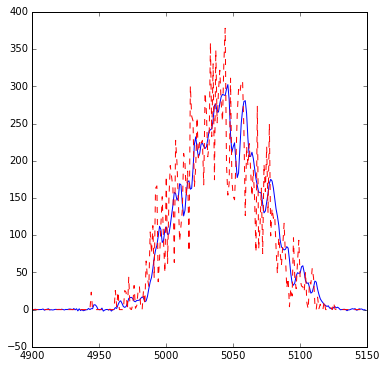

Reconstructed Energy = 19714.6417513
Error in Energy Computation (%) = 0.0426806096867
Press a key...
event = 8
baseline = 2499.96204313, noise (LSB_rms) = 0.872668409302 MAU[nm] =0.0 
Input Energy = 20380.3607001


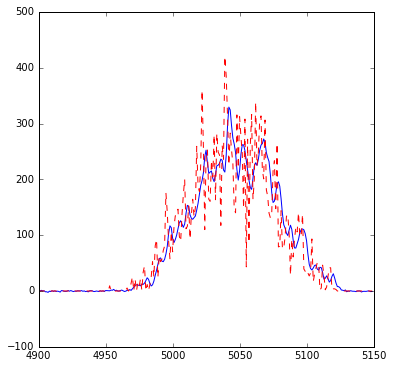

Reconstructed Energy = 20346.0711873
Error in Energy Computation (%) = 0.168247821461
Press a key...
event = 9
baseline = 2500.07692316, noise (LSB_rms) = 0.83639715364 MAU[nm] =0.0 
Input Energy = 20228.3180926


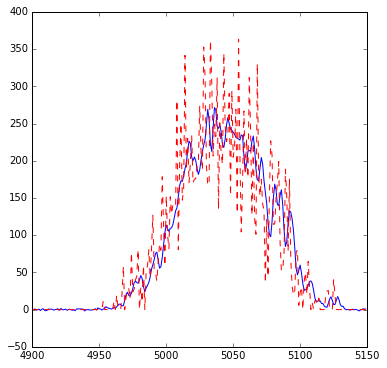

Reconstructed Energy = 20258.0298752
Error in Energy Computation (%) = 0.146882120489
Press a key...


In [116]:
ER = blr_stats(e40.root.pmtrd, event_list=range(10), xmin=4900, xmax=5150, pmtid=0, plot=True)

In [117]:
ER = blr_stats(e40.root.pmtrd, event_list=range(100), xmin=4900, xmax=5150, pmtid=0, plot=False)

event = 0
baseline = 2500.03554057, noise (LSB_rms) = 0.892354863488 MAU[nm] =0.0 
event = 1
baseline = 2499.99384362, noise (LSB_rms) = 0.833919445567 MAU[nm] =0.0 
event = 2
baseline = 2499.95722947, noise (LSB_rms) = 0.89161423944 MAU[nm] =0.0 
event = 3
baseline = 2499.98221661, noise (LSB_rms) = 0.854465916275 MAU[nm] =0.0 
event = 4
baseline = 2500.02307065, noise (LSB_rms) = 0.884613661331 MAU[nm] =0.0 
event = 5
baseline = 2500.09036127, noise (LSB_rms) = 0.90448384269 MAU[nm] =0.0 
event = 6
baseline = 2500.03573237, noise (LSB_rms) = 0.862511320316 MAU[nm] =0.0 
event = 7
baseline = 2499.97602579, noise (LSB_rms) = 0.84147752083 MAU[nm] =0.0 
event = 8
baseline = 2499.97403813, noise (LSB_rms) = 0.855712821562 MAU[nm] =0.0 
event = 9
baseline = 2500.03709058, noise (LSB_rms) = 0.909549874735 MAU[nm] =0.0 
event = 10
baseline = 2499.99428899, noise (LSB_rms) = 0.885539456599 MAU[nm] =0.0 
event = 11
baseline = 2499.99021482, noise (LSB_rms) = 0.865745734608 MAU[nm] =0.0 
event

(array([ 32.,  15.,  22.,  14.,   8.,   3.,   4.,   0.,   0.,   2.]),
 array([  3.49243737e-04,   4.29757364e-02,   8.56022291e-02,
          1.28228722e-01,   1.70855214e-01,   2.13481707e-01,
          2.56108200e-01,   2.98734692e-01,   3.41361185e-01,
          3.83987678e-01,   4.26614170e-01]),
 <a list of 10 Patch objects>)

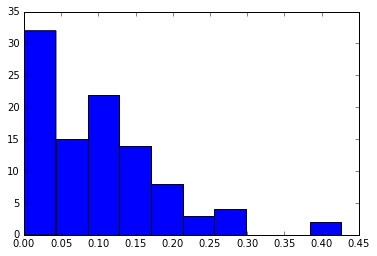

In [315]:
plt.hist(ER)

event = 0
baseline = 2499.96343657 noise (LSB_rms) = 0.854299853414
trigger line = 4.27149926707 LSB
Input Energy = 20735.9714787
Reconstructed Energy = 20709.0485842
Error in Energy Computation (%) = 0.129836668552


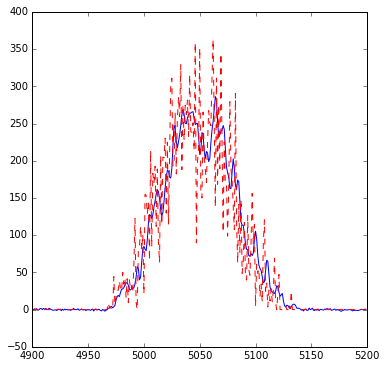

In [318]:
ER = blr_stats(e40.root.pmtrd, event_list=range(1), xmin=4900, xmax=5200, pmtid=1, plot=True)

In [319]:
ER = blr_stats(e40.root.pmtrd, event_list=range(100), xmin=4950, xmax=5150, pmtid=1, plot=False)

event = 0
baseline = 2500.0011182 noise (LSB_rms) = 0.851431386657
trigger line = 4.25715693329 LSB
event = 1
baseline = 2500.06186853 noise (LSB_rms) = 0.826899921678
trigger line = 4.13449960839 LSB
event = 2
baseline = 2500.03151759 noise (LSB_rms) = 0.911168086751
trigger line = 4.55584043376 LSB
event = 3
baseline = 2499.99516582 noise (LSB_rms) = 0.853909021992
trigger line = 4.26954510996 LSB
event = 4
baseline = 2499.97079055 noise (LSB_rms) = 0.873863037007
trigger line = 4.36931518504 LSB
event = 5
baseline = 2499.94369951 noise (LSB_rms) = 0.87476364144
trigger line = 4.3738182072 LSB
event = 6
baseline = 2500.02438939 noise (LSB_rms) = 0.876263121368
trigger line = 4.38131560684 LSB
event = 7
baseline = 2500.05750087 noise (LSB_rms) = 0.882656965932
trigger line = 4.41328482966 LSB
event = 8
baseline = 2500.01011583 noise (LSB_rms) = 0.877339663711
trigger line = 4.38669831855 LSB
event = 9
baseline = 2499.97708283 noise (LSB_rms) = 0.852057834379
trigger line = 4.260289171

(array([ 24.,  12.,  15.,  12.,  12.,   6.,   7.,   5.,   2.,   5.]),
 array([ 0.00319808,  0.02962076,  0.05604344,  0.08246612,  0.1088888 ,
         0.13531148,  0.16173416,  0.18815684,  0.21457952,  0.2410022 ,
         0.26742488]),
 <a list of 10 Patch objects>)

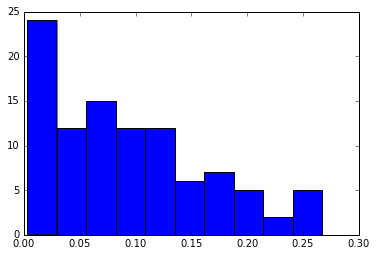

In [118]:
plt.hist(ER)

### Electrons of 1250 MeV

In [119]:
RWF, BLRX = fee_response(e1250.root.pmtrd, event=0) 

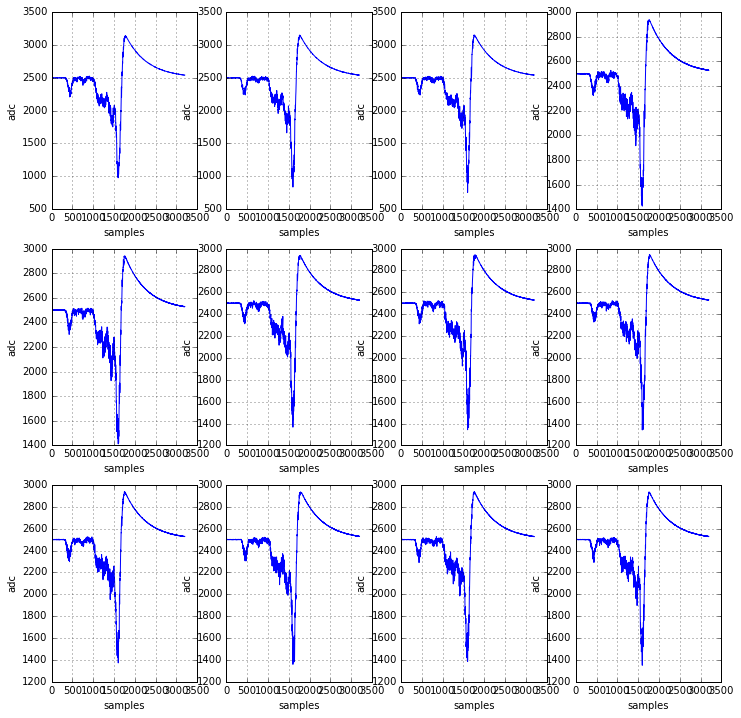

In [120]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=1600)

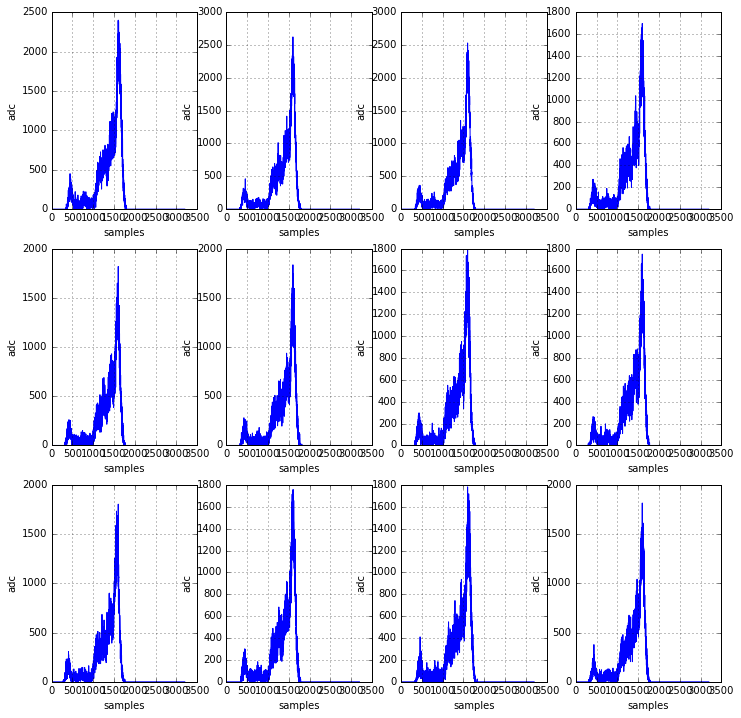

In [121]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=True, window_size=1600)

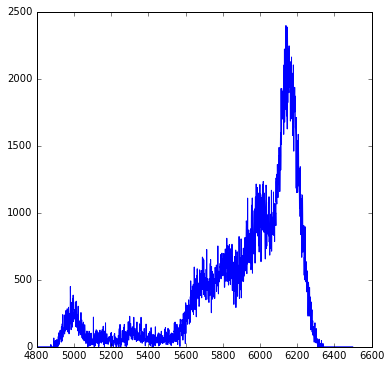

In [122]:
plt.figure(figsize=(6, 6))
xmin=4800
xmax=6500
plt.plot(range(xmin,xmax),BLRX[0][xmin:xmax])

event = 0
baseline = 2499.92993809, noise (LSB_rms) = 0.860481904603 MAU[nm] =0.0 
Input Energy = 629974.086925


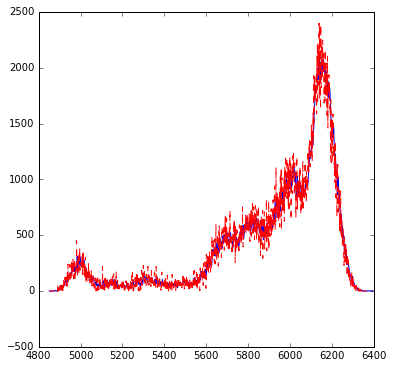

Reconstructed Energy = 630420.285119
Error in Energy Computation (%) = 0.0708280234191
Press a key...


In [123]:
ER = blr_stats(e1250.root.pmtrd, event_list=range(1), xmin=4850, xmax=6400, pmtid=0, plot=True)

event = 0
baseline = 2500.05181431, noise (LSB_rms) = 0.898688576486 MAU[nm] =0.0 
Input Energy = 630329.470288


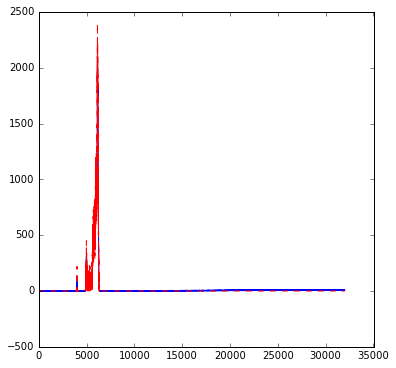

Reconstructed Energy = 754876.231464
Error in Energy Computation (%) = 19.7589938353
Press a key...


In [125]:
ER = blr_stats(e1250.root.pmtrd, event_list=range(1), xmin=0, xmax=32000, pmtid=0, plot=True)

In [126]:
RWF, BLRX = fee_response(e2500.root.pmtrd, event=0) 

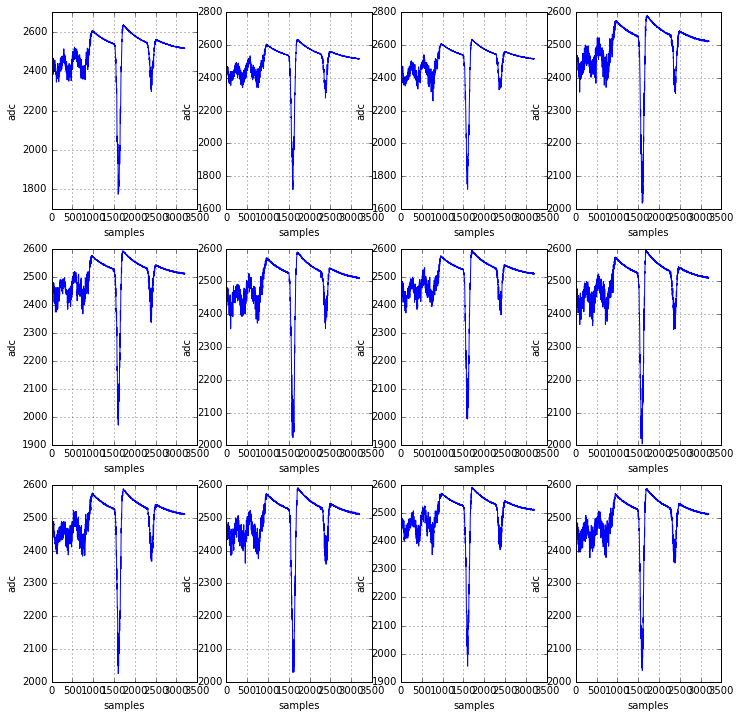

In [127]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=1600)

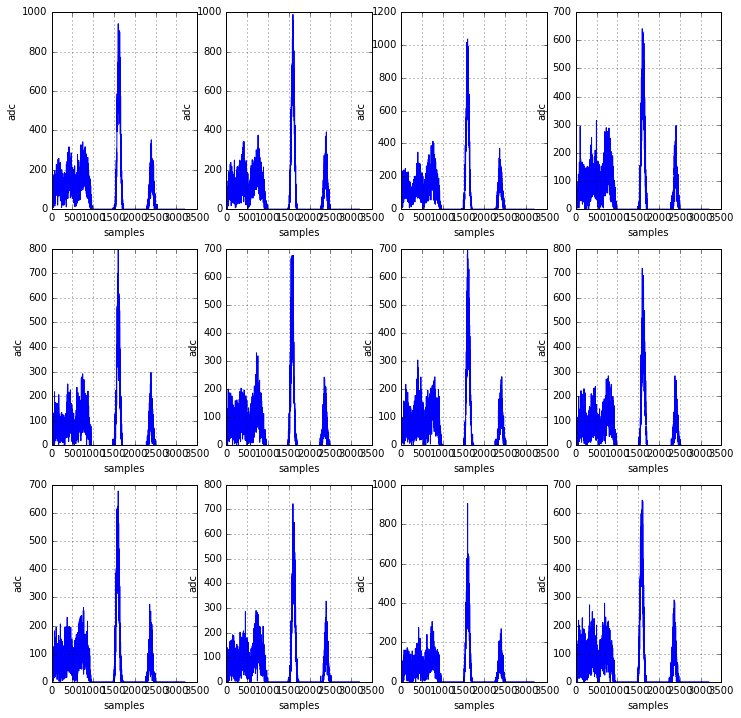

In [128]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=True, window_size=1600)

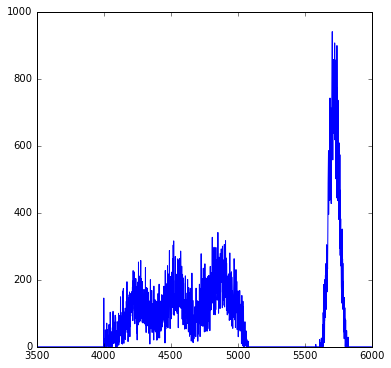

In [129]:
plt.figure(figsize=(6, 6))
xmin=3500
xmax=6000
plt.plot(range(xmin,xmax),BLRX[0][xmin:xmax])

event = 0
baseline = 2499.98544026, noise (LSB_rms) = 0.859312938749 MAU[nm] =0.0 
Input Energy = 193903.8469


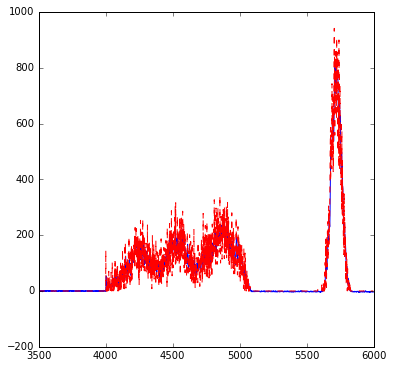

Reconstructed Energy = 191386.207291
Error in Energy Computation (%) = 1.29839590572
Press a key...


In [130]:
ER = blr_stats(e2500.root.pmtrd, event_list=range(1), xmin=3500, xmax=6000, pmtid=0, plot=True)

event = 0
baseline = 2499.97774442, noise (LSB_rms) = 0.870896077883 MAU[nm] =0.0 
Input Energy = 214421.563923


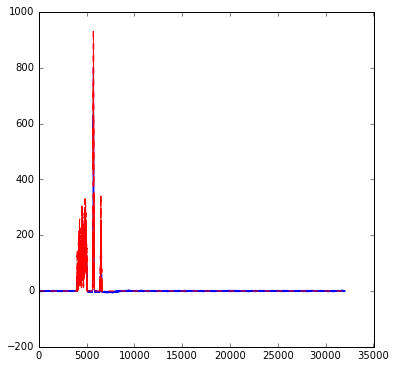

Reconstructed Energy = 204201.558049
Error in Energy Computation (%) = 4.76631439849
Press a key...


In [131]:
ER = blr_stats(e2500.root.pmtrd, event_list=range(1), xmin=0, xmax=32000, pmtid=0, plot=True)

#### Deconvolution seems to work very well in the MC

In [139]:
e2644 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2644.gdc1next.000.next1el_2644.root.h5','r+')

In [140]:
kr2609 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2609_kr.root.h5','r+')

## Deconvolution in data

In [191]:
dataPMT

,channel,pmtid,active,x,y,coeff_c,coeff_blr,adc_to_pes,noise_rms
0,0,1,1,-23.941401,65.778503,0.000003,0.001632,-22.9168,0.7060
1,18,3,1,-44.995098,-53.623100,0.000003,0.001632,-23.7510,0.8744
2,1,2,1,68.936501,-12.155400,0.000003,0.001611,-25.3008,0.7213
3,19,4,1,0.000000,185.000000,0.000003,0.001599,-25.9984,0.7624
4,27,C,1,-118.916000,141.718002,0.000003,0.001567,-23.7074,0.7921
5,26,B,1,-182.188995,32.124901,0.000004,0.001650,-20.8927,0.8660
6,9,A,1,-160.214996,-92.500000,0.000003,0.001593,-22.1340,0.7062
7,8,9,1,-63.273701,-173.843002,0.000003,0.001612,-33.0993,0.7278
8,23,8,1,63.273701,-173.843002,0.000003,0.001601,-20.4377,0.7303
9,22,7,1,160.214996,-92.500000,0.000003,0.001593,-25.1698,0.7160


In [192]:
dataPMT.coeff_blr.values

array([ 0.00163241,  0.00163241,  0.0016111 ,  0.00159936,  0.00156696,
        0.00164962,  0.00159296,  0.00161207,  0.00160068,  0.00159272,
        0.00157519,  0.00159632])

In [190]:
dataPMT.coeff_c.values

array([  2.90544700e-06,   3.08000000e-06,   2.80060000e-06,
         2.75626500e-06,   3.13876600e-06,   3.96517600e-06,
         2.71100000e-06,   3.12764100e-06,   3.06454300e-06,
         3.04046300e-06,   3.11360400e-06,   3.18597900e-06])

### Values from VHB (12-11-016)

pmtID = ['1','3','2','4',
         'C','B','A','9',
         '8','7','6','5']
elecID = [0, 18,  1, 19,  27, 26, 9,  8, 23, 22,  5,  4]
noise_rms = [0.7060,0.8744,0.7213,0.7624,
             0.7921,0.8660,0.7062,0.7278,
             0.7303,0.7160,0.7323,0.7206]
coef_c = [2.905447E-06,3.085705E-06,2.806061E-06,2.756265E-06,
          3.138766E-06,3.965176E-06,2.711644E-06,3.127641E-06,
          3.064543E-06,3.040463E-06,3.113604E-06,3.185979E-06]
coef_blr = [1.632411E-03,1.610050E-03,1.611104E-03,1.599356E-03,
            1.566958E-03,1.649618E-03,1.592963E-03,1.612068E-03,
            1.600683E-03,1.592718E-03,1.575192E-03,1.596322E-03]


### Kripton

In [143]:
pmtrwf = kr2609.root.RD.pmtrwf

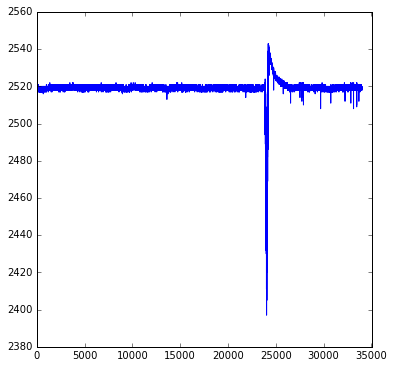

In [146]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=34000
plt.plot(range(xmin,xmax),pmtrwf[0,0][xmin:xmax])

In [171]:
event = 0
pmt = 0
BLR = deconvolve_signal_acum(pmtrwf[event,pmt], n_baseline=500, noise_rms= 0.8,
                      coef_clean=dataPMT.coeff_c[0], coef_blr=dataPMT.coeff_blr[0], 
                      thr_trigger=5, thr_acum=700, coeff_acum = 0.9995,
                      acum_discharge_length = 5000, acum_tau=2500, acum_compress=0.0025,
                      filter_c=True)

baseline = 2518.802, noise (LSB_rms) = 0.810005071856 MAU[nm] =0.0 


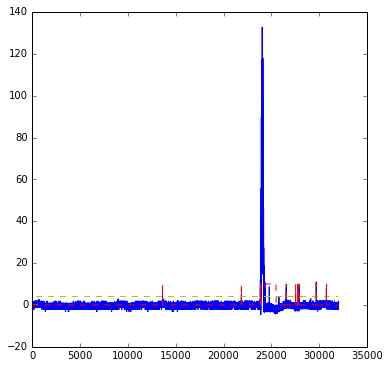

In [172]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=32000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

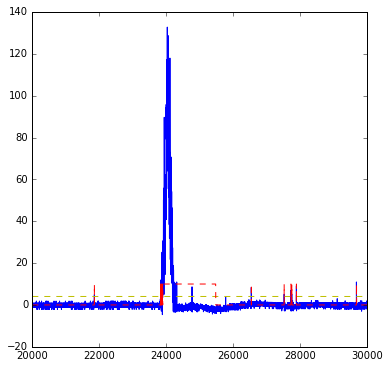

In [173]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR.signal_daq[xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

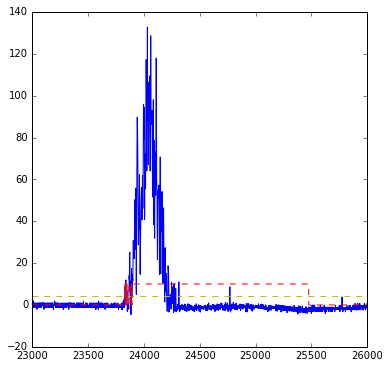

In [176]:
plt.figure(figsize=(6, 6))
xmin=23000
xmax=26000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR.signal_daq[xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

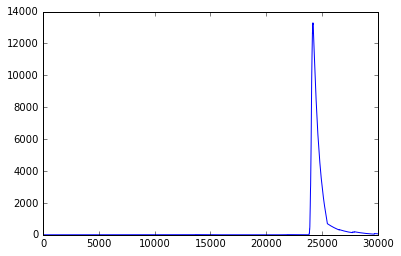

In [174]:
xmin=0
xmax=30000
plt.plot(range(xmin,xmax),BLR.acum[xmin:xmax])

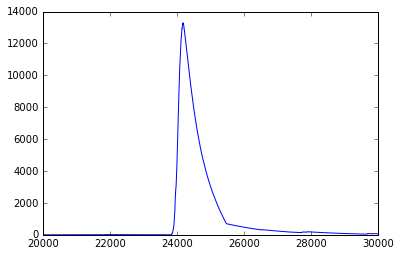

In [175]:
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),BLR.acum[xmin:xmax])

In [177]:
pmtrwf = e2644.root.RD.pmtrwf

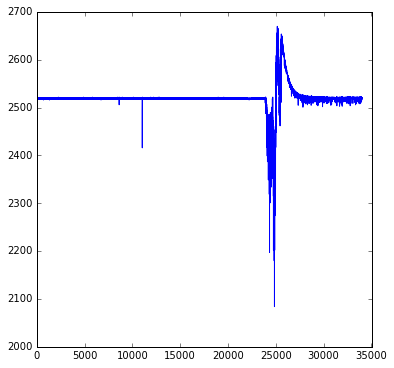

In [178]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=34000
plt.plot(range(xmin,xmax),pmtrwf[0,0][xmin:xmax])

In [182]:
event = 0
pmt = 0
BLR = deconvolve_signal_acum(pmtrwf[event,pmt], n_baseline=500, noise_rms= 0.8,
                      coef_clean=dataPMT.coeff_c[0], coef_blr=dataPMT.coeff_blr[0], 
                      thr_trigger=5, thr_acum=700, coeff_acum = 0.9995,
                      acum_discharge_length = 5000, acum_tau=2500, acum_compress=0.0025,
                      filter_c=True)

baseline = 2518.776, noise (LSB_rms) = 0.75029987325 MAU[nm] =0.0 


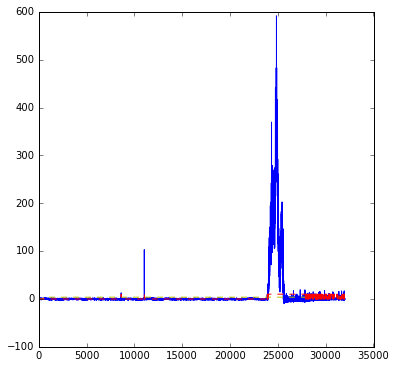

In [183]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=32000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

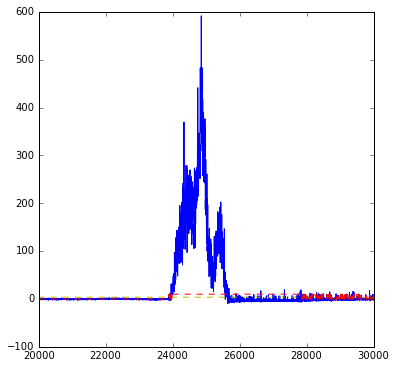

In [184]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR.signal_daq[xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)

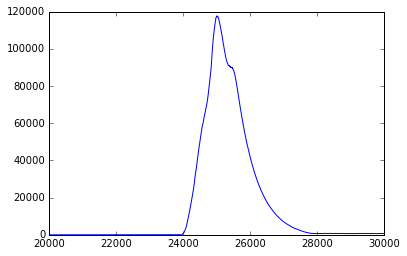

In [185]:
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),BLR.acum[xmin:xmax])